# Importing Libraries

In [17]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.linear_model import LinearRegression

from tqdm import tqdm


NUM_DATAPOINTS = 100
NUM_SAMPLES = 200
NOISE_STD_DEV = 20

# Utility functions

In [98]:
# True function
def f(x):
    return 2*x + 3

def plot_true_function(label='y = 2x + 3'):
    x = np.linspace(-10, 10, 100)
    plt.plot(x, f(x), label=label)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('True Function')
    plt.legend()

    plt.grid(True)
    plt.show()


def generate_data(num_datapoints=NUM_DATAPOINTS,
                  num_samples=NUM_SAMPLES, 
                  noise_std_dev=NOISE_STD_DEV):
    np.random.seed(42)
    x_values = np.random.choice(range(-num_datapoints, num_datapoints+1, 1), 
                                 size=num_datapoints,
                                 replace=False)

    # Add random noise to y values for each sample

    samples = []
    for i in tqdm(range(num_samples), total=num_samples):
        one_sample_set = []
        for x in x_values:
            y_true = f(x)

            # Add random noise to y
            noise = np.random.normal(0, noise_std_dev)
            y_with_noise = y_true + noise

            # Store the sample dataset as a tuple (x, y_with_noise)
            one_sample_set.append((x, y_with_noise))

        samples.append(np.array(one_sample_set))
    return samples
   

def plot_true_function_with_data(data, figsize=(10,6),zoom_in=None):
    # Plot the true function
    x = data[:, 0]
    y_with_noise = data[:, 1]
    true_function_values = f(x)

    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(x, true_function_values, label='True Function: $y = 2x + 3$', color='blue', linewidth=1)
    ax.scatter(x, y_with_noise, color='red', label='Sample Data with Noise', s=5)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()

    if zoom_in:
        inset_axes_obj = inset_axes(ax, width="30%", height="30%", loc="lower right")
        inset_axes_obj.plot(x, true_function_values, color='blue', linewidth=1)
        inset_axes_obj.scatter(x, y_with_noise, color='red', s=4)
        inset_axes_obj.set_xlim(zoom_in)
        inset_axes_obj.set_title(f'Zoomed In:{zoom_in}')

    if zoom_in:
        ax.set_title(f'True Function with Sample Data; zoomed in={zoom_in}')
    else:
        ax.set_title('True Function with Sample Data')

    ax.grid(True)
    plt.show()

    

def plot_regression_lines(datasets, models, figsize=(10,6)):
    plt.figure(figsize=figsize)
    
    # Plot regression lines
    for model, data in zip(models, datasets):
        X_range = np.linspace(min(data[:, 0]), 
                              max(data[:, 0]), 
                              num=100).reshape(-1, 1)
        y_pred = model.predict(X_range)
        plt.plot(X_range, y_pred, linewidth=1)
    
    true_function_values = f(X_range)
    
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title('Regression Lines')
    # plt.legend(['Regression Line' + str(i+1) for i in range(len(models))])
    plt.grid(True)
    plt.show()

# Creating Data

Lets first assume the true function, $$y=f(x) + \epsilon = 2x + 3 + \epsilon$$ where $\epsilon$ is the irreducible error

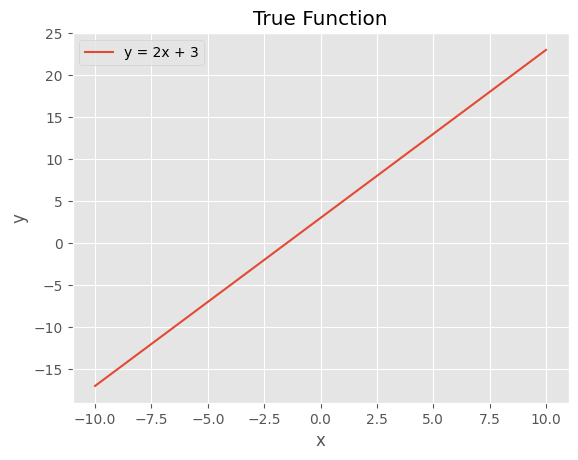

In [8]:
plot_true_function()

Now lets create 200 sample datasets for randomly sampled 100 x from {-100, -99, ..., +99, +100}

In [19]:
# Set a seed for reproducibility
samples = generate_data()

100%|███████████████████████████████████████| 200/200 [00:00<00:00, 2174.26it/s]


Visualizing one sample dataset with the true functional values ...

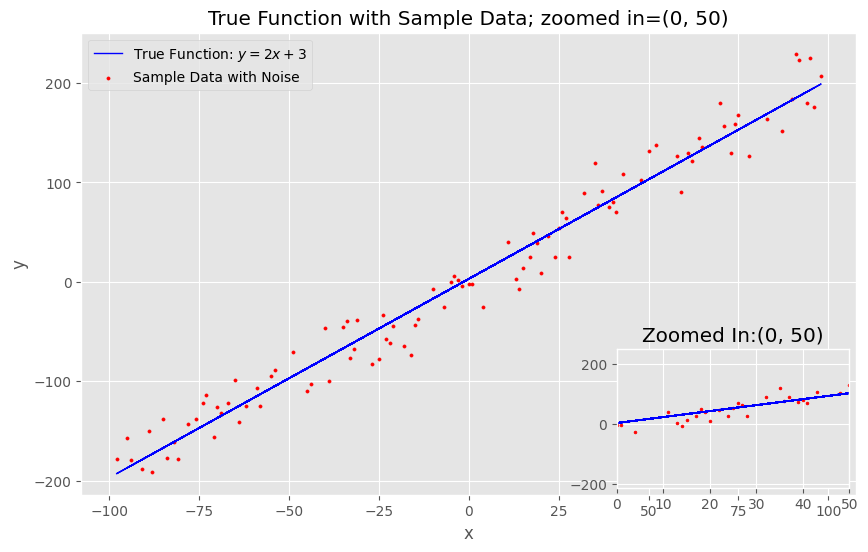

In [20]:
plot_true_function_with_data(samples[10], zoom_in=(0, 50))

# Modelling

## Linear Regression

In [11]:
samples[0][0:10,:]

array([[  -5.        ,  -18.49418415],
       [ -85.        , -175.42996441],
       [ -70.        , -130.20358072],
       [  58.        ,  118.852397  ],
       [  28.        ,   74.34593677],
       [  15.        ,   10.00414845],
       [ -31.        ,  -74.50672212],
       [  71.        ,  160.46281712],
       [  75.        ,  136.96344313],
       [ -55.        ,  -79.31968562]])

In [14]:

models = []

for data in tqdm(samples, total=len(samples)):
    X = data[:,0].reshape(-1,1)
    y = data[:,1].reshape(-1,1)

    # Train the linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    models.append(model)

100%|███████████████████████████████████████| 200/200 [00:00<00:00, 1838.29it/s]


In [87]:
predictions_across_samples = []

for data,model in tqdm(zip(samples,models), total=len(samples)):
    predictions = model.predict(data[:,0].reshape(-1,1))
    predictions_across_samples.append(predictions.reshape(-1,))

100%|██████████████████████████████████████| 200/200 [00:00<00:00, 13990.81it/s]


In [89]:
g_bars = np.sum(np.array(predictions_across_samples), axis=0)/NUM_SAMPLES
y_bars = np.sum(np.array(samples)[:,:,1], axis=0)/NUM_SAMPLES

bias_squared_for_each_xi = (y_bars - g_bars)**2
bias_squared = np.sum(bias_squared_for_each_xi)/NUM_DATAPOINTS

print("Bias of the hypothesis function : ", round(np.sqrt(bias_squared),2))

Bias of the hypothesis function :  1.48


In [90]:
g_bars = np.sum(np.array(predictions_across_samples), axis=0)/NUM_SAMPLES
distances = (np.array(predictions_across_samples) - g_bars)**2

var_for_each_xi = np.sum(distances, axis=0)/NUM_SAMPLES
variance = np.sum(var_for_each_xi)/NUM_DATAPOINTS

print("Variance of the hypothesis function : ", round(variance,2))

Variance of the hypothesis function :  7.53


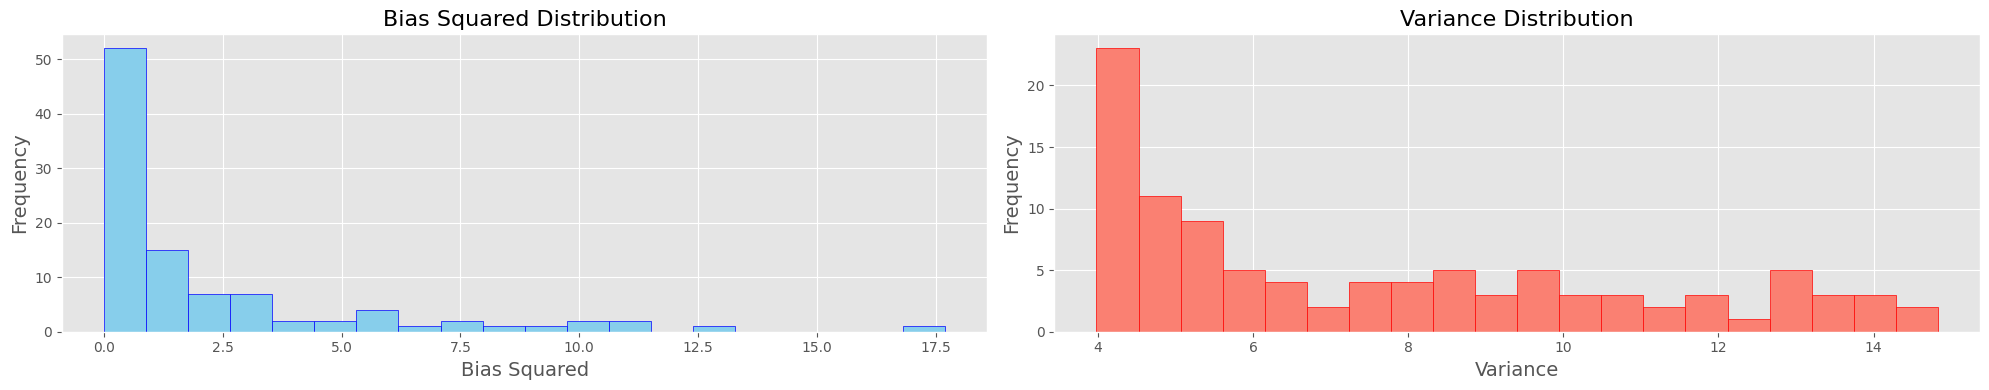

In [86]:
plt.figure(figsize=(20,4))

# Plot the first histogram
plt.subplot(121)
plt.hist(bias_squared_for_every_xi, bins=20, color='skyblue', edgecolor="blue")
plt.title('Bias Squared Distribution', fontsize=16)
plt.xlabel('Bias Squared', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)

# Plot the second histogram
plt.subplot(122)
plt.hist(var_for_each_xi, bins=20, color='salmon', edgecolor="red")
plt.title('Variance Distribution', fontsize=16)
plt.xlabel('Variance', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)

# Adjust layout spacing
plt.tight_layout()

# Show the plot
plt.show()

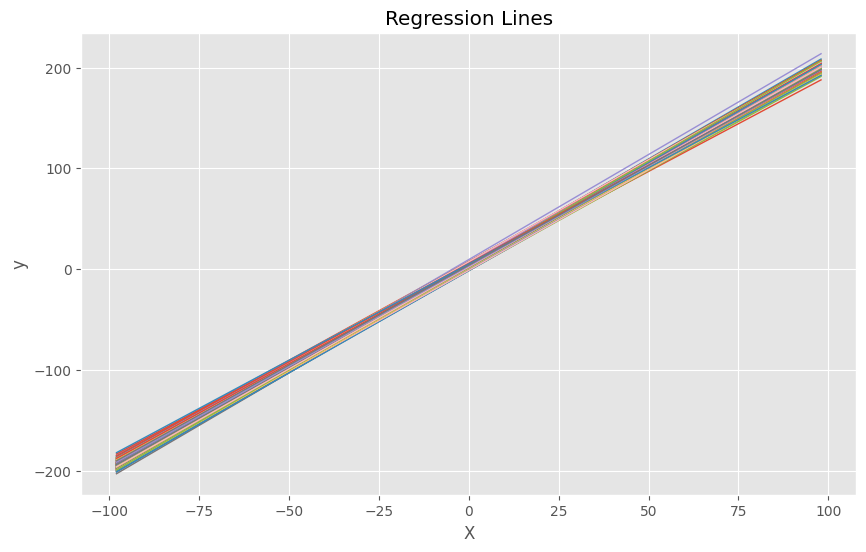

In [99]:
plot_regression_lines(samples, models)

## Polynomial Regression

In [95]:
min(data[:, 0] for data in samples)

-98.0